# Análisis de Muestra MEG de 1 Minuto
## LibriBrain Competition - Preprocesamiento y Análisis

Este notebook se enfoca en analizar una muestra específica de 1 minuto de los datos MEG para entender mejor:
- Estructura temporal de los datos
- Patrones de activación de sensores
- Características de las señales de habla vs silencio
- Visualizaciones detalladas de la actividad cerebral

In [2]:
# Importaciones necesarias
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import json
import os
from scipy import signal
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [3]:
# Configuración de rutas
base_path = "c:/Users/jp/Repositorios/LibriBrian_Competition/libribrain"

# Rutas de archivos
hdf5_file_path = f"{base_path}/data/Sherlock1/derivatives/serialised/sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"
sensor_file_path = f"{base_path}/sensor_xyz.json"

# Constantes
SFREQ = 250  # Frecuencia de muestreo (Hz)
MINUTE_IN_SAMPLES = SFREQ * 60  # Muestras en 1 minuto (15,000)

print(f"📁 Base path: {base_path}")
print(f"📊 Frecuencia de muestreo: {SFREQ} Hz")
print(f"⏱️ Muestras por minuto: {MINUTE_IN_SAMPLES}")

📁 Base path: c:/Users/jp/Repositorios/LibriBrian_Competition/libribrain
📊 Frecuencia de muestreo: 250 Hz
⏱️ Muestras por minuto: 15000


In [4]:
# Cargar datos MEG
print("🔄 Cargando datos MEG...")

with h5py.File(hdf5_file_path, "r") as f:
    # Cargar datos completos
    raw_data = f["data"][:]  # Shape: (306 sensores, timepoints)
    times = f["times"][:]    # Timestamps en segundos
    
print(f"📊 Datos cargados:")
print(f"   - Shape: {raw_data.shape}")
print(f"   - Duración total: {times[-1]:.2f} segundos ({times[-1]/60:.2f} minutos)")
print(f"   - Número de sensores: {raw_data.shape[0]}")
print(f"   - Número de muestras temporales: {raw_data.shape[1]}")

# Extraer 1 minuto específico (del minuto 5 al 6, por ejemplo)
start_time = 5 * 60  # Empezar en el segundo 300 (minuto 5)
end_time = start_time + 60  # Terminar en el segundo 360 (minuto 6)

# Convertir a índices
start_idx = int(start_time * SFREQ)
end_idx = int(end_time * SFREQ)

# Extraer la muestra de 1 minuto
meg_1min = raw_data[:, start_idx:end_idx]
times_1min = times[start_idx:end_idx] - times[start_idx]  # Normalizar tiempo

print(f"\n🎯 Muestra extraída:")
print(f"   - Tiempo: {start_time}s - {end_time}s")
print(f"   - Shape: {meg_1min.shape}")
print(f"   - Duración: {times_1min[-1]:.2f} segundos")

🔄 Cargando datos MEG...
📊 Datos cargados:
   - Shape: (306, 278000)
   - Duración total: 1112.00 segundos (18.53 minutos)
   - Número de sensores: 306
   - Número de muestras temporales: 278000

🎯 Muestra extraída:
   - Tiempo: 300s - 360s
   - Shape: (306, 15000)
   - Duración: 60.00 segundos


In [8]:
# Cargar posiciones de sensores
print("🔄 Cargando posiciones de sensores...")

try:
    with open(sensor_file_path, "r") as fp:
        sensor_xyz = np.array(json.load(fp))
    print(f"✅ Posiciones de sensores cargadas: {sensor_xyz.shape}")
except FileNotFoundError:
    print("⚠️ Archivo de sensores no encontrado. Descargando...")
    import requests
    os.makedirs(os.path.dirname(sensor_file_path), exist_ok=True)
    
    response = requests.get("https://neural-processing-lab.github.io/2025-libribrain-competition/sensor_xyz.json")
    with open(sensor_file_path, "wb") as f:
        f.write(response.content)
    
    with open(sensor_file_path, "r") as fp:
        sensor_xyz = np.array(json.load(fp))
    print(f"✅ Descargado y cargado: {sensor_xyz.shape}")

# Sensores importantes para detección de habla (identificados previamente)
SPEECH_SENSORS = [18, 20, 22, 23, 45, 120, 138, 140, 142, 143, 145,
                  146, 147, 149, 175, 176, 177, 179, 180, 198, 271, 272, 275]

print(f"🎯 Sensores importantes para habla: {len(SPEECH_SENSORS)} de {len(sensor_xyz)}")
print(f"   Índices: {SPEECH_SENSORS[:]}")

🔄 Cargando posiciones de sensores...
✅ Posiciones de sensores cargadas: (306, 3)
🎯 Sensores importantes para habla: 23 de 306
   Índices: [18, 20, 22, 23, 45, 120, 138, 140, 142, 143, 145, 146, 147, 149, 175, 176, 177, 179, 180, 198, 271, 272, 275]


## 📊 Análisis Estadístico de la Muestra

Primero examinemos las características estadísticas básicas de los datos de 1 minuto.

In [9]:
# Estadísticas descriptivas
print("📊 ESTADÍSTICAS DESCRIPTIVAS DE LA MUESTRA DE 1 MINUTO")
print("="*60)

# Estadísticas globales
global_mean = np.mean(meg_1min)
global_std = np.std(meg_1min)
global_min = np.min(meg_1min)
global_max = np.max(meg_1min)

print(f"🌍 ESTADÍSTICAS GLOBALES:")
print(f"   Media global:           {global_mean:.2e}")
print(f"   Desviación estándar:    {global_std:.2e}")
print(f"   Valor mínimo:           {global_min:.2e}")
print(f"   Valor máximo:           {global_max:.2e}")
print(f"   Rango:                  {global_max - global_min:.2e}")

# Estadísticas por sensor
sensor_means = np.mean(meg_1min, axis=1)
sensor_stds = np.std(meg_1min, axis=1)
sensor_vars = np.var(meg_1min, axis=1)

print(f"\n🎯 ESTADÍSTICAS POR SENSOR:")
print(f"   Sensor más activo (mayor std):  #{np.argmax(sensor_stds)} (std={sensor_stds[np.argmax(sensor_stds)]:.2e})")
print(f"   Sensor menos activo (menor std): #{np.argmin(sensor_stds)} (std={sensor_stds[np.argmin(sensor_stds)]:.2e})")

# Estadísticas de sensores importantes
speech_sensor_means = sensor_means[SPEECH_SENSORS]
speech_sensor_stds = sensor_stds[SPEECH_SENSORS]

print(f"\n🗣️ SENSORES DE HABLA:")
print(f"   Media promedio:         {np.mean(speech_sensor_means):.2e}")
print(f"   Std promedio:           {np.mean(speech_sensor_stds):.2e}")
print(f"   Sensor más activo:      #{SPEECH_SENSORS[np.argmax(speech_sensor_stds)]}")
print(f"   Sensor menos activo:    #{SPEECH_SENSORS[np.argmin(speech_sensor_stds)]}")

📊 ESTADÍSTICAS DESCRIPTIVAS DE LA MUESTRA DE 1 MINUTO
🌍 ESTADÍSTICAS GLOBALES:
   Media global:           4.61e-14
   Desviación estándar:    8.22e-12
   Valor mínimo:           -1.37e-10
   Valor máximo:           1.33e-10
   Rango:                  2.70e-10

🎯 ESTADÍSTICAS POR SENSOR:
   Sensor más activo (mayor std):  #254 (std=2.35e-11)
   Sensor menos activo (menor std): #84 (std=1.57e-13)

🗣️ SENSORES DE HABLA:
   Media promedio:         4.71e-14
   Std promedio:           6.85e-12
   Sensor más activo:      #271
   Sensor menos activo:    #180


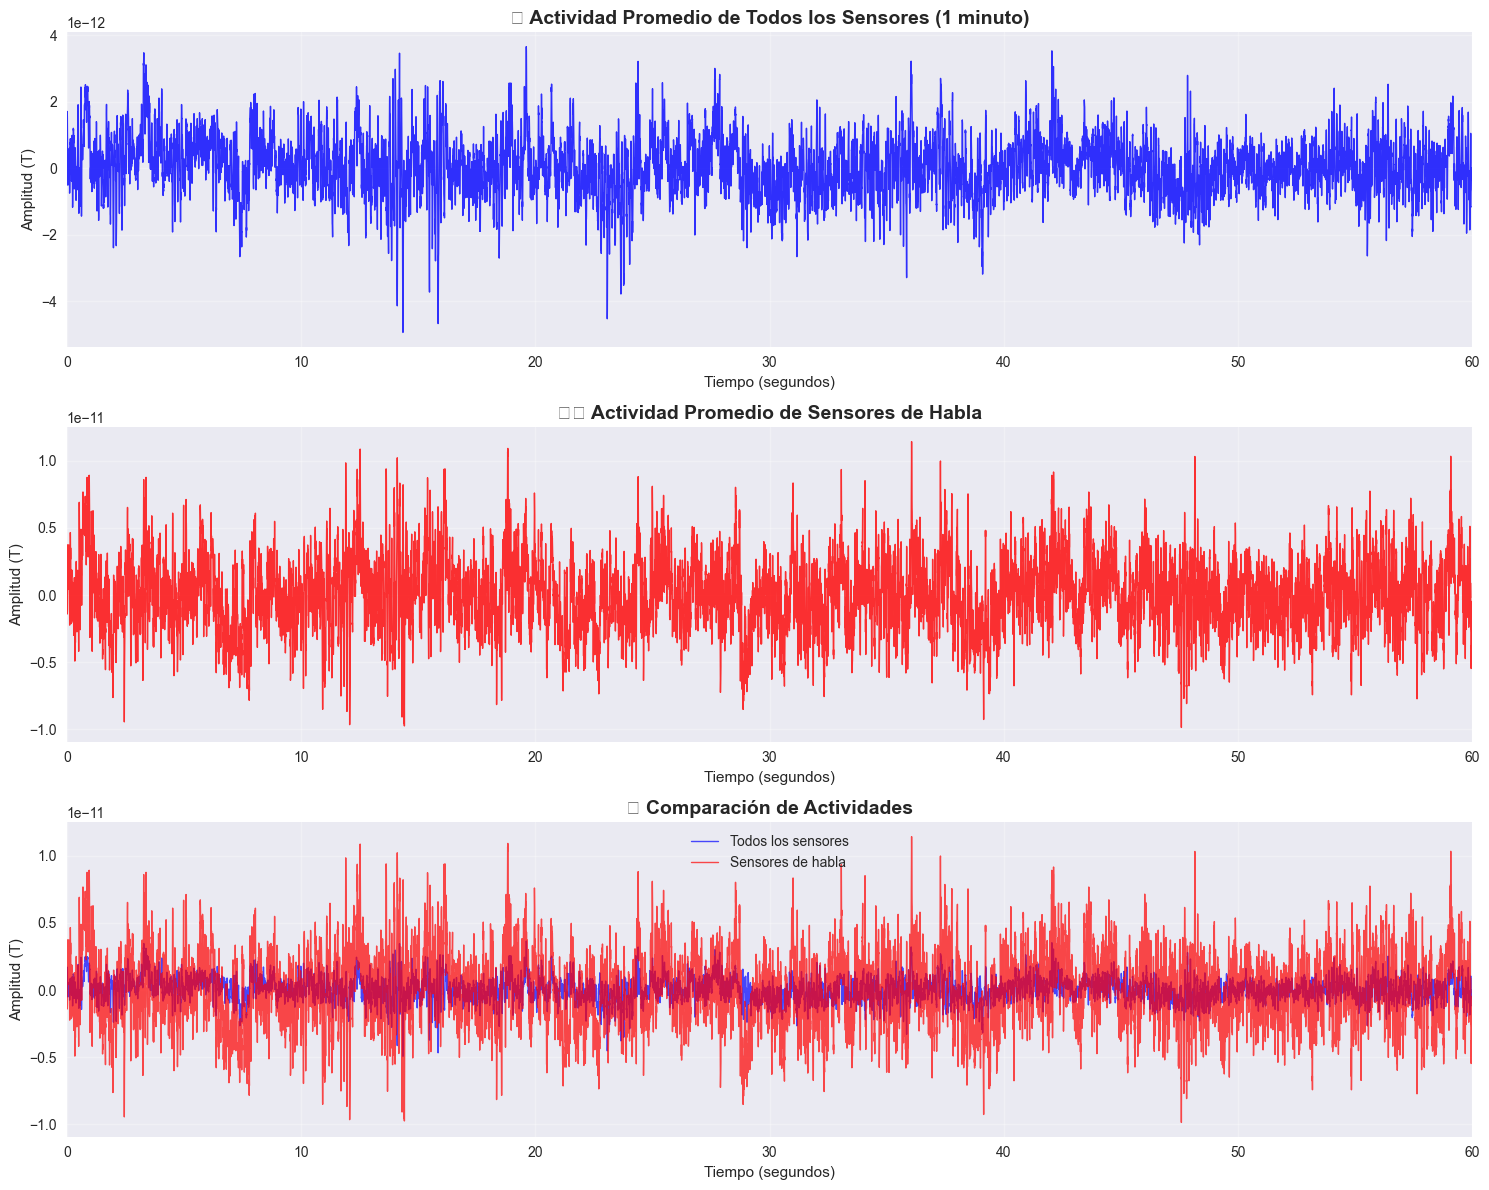

🔗 Correlación entre actividad general y sensores de habla: 0.307


In [10]:
# Visualización de la actividad temporal
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Actividad promedio de todos los sensores
avg_activity = np.mean(meg_1min, axis=0)
axes[0].plot(times_1min, avg_activity, 'b-', linewidth=1, alpha=0.8)
axes[0].set_title('🌍 Actividad Promedio de Todos los Sensores (1 minuto)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tiempo (segundos)')
axes[0].set_ylabel('Amplitud (T)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 60)

# 2. Actividad de sensores importantes para habla
speech_activity = np.mean(meg_1min[SPEECH_SENSORS, :], axis=0)
axes[1].plot(times_1min, speech_activity, 'r-', linewidth=1, alpha=0.8)
axes[1].set_title('🗣️ Actividad Promedio de Sensores de Habla', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tiempo (segundos)')
axes[1].set_ylabel('Amplitud (T)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 60)

# 3. Comparación de ambos
axes[2].plot(times_1min, avg_activity, 'b-', linewidth=1, alpha=0.7, label='Todos los sensores')
axes[2].plot(times_1min, speech_activity, 'r-', linewidth=1, alpha=0.7, label='Sensores de habla')
axes[2].set_title('📊 Comparación de Actividades', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Tiempo (segundos)')
axes[2].set_ylabel('Amplitud (T)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 60)

plt.tight_layout()
plt.show()

# Calcular correlación entre actividades
correlation = pearsonr(avg_activity, speech_activity)[0]
print(f"🔗 Correlación entre actividad general y sensores de habla: {correlation:.3f}")

🎨 Creando heatmap de actividad de sensores de habla...


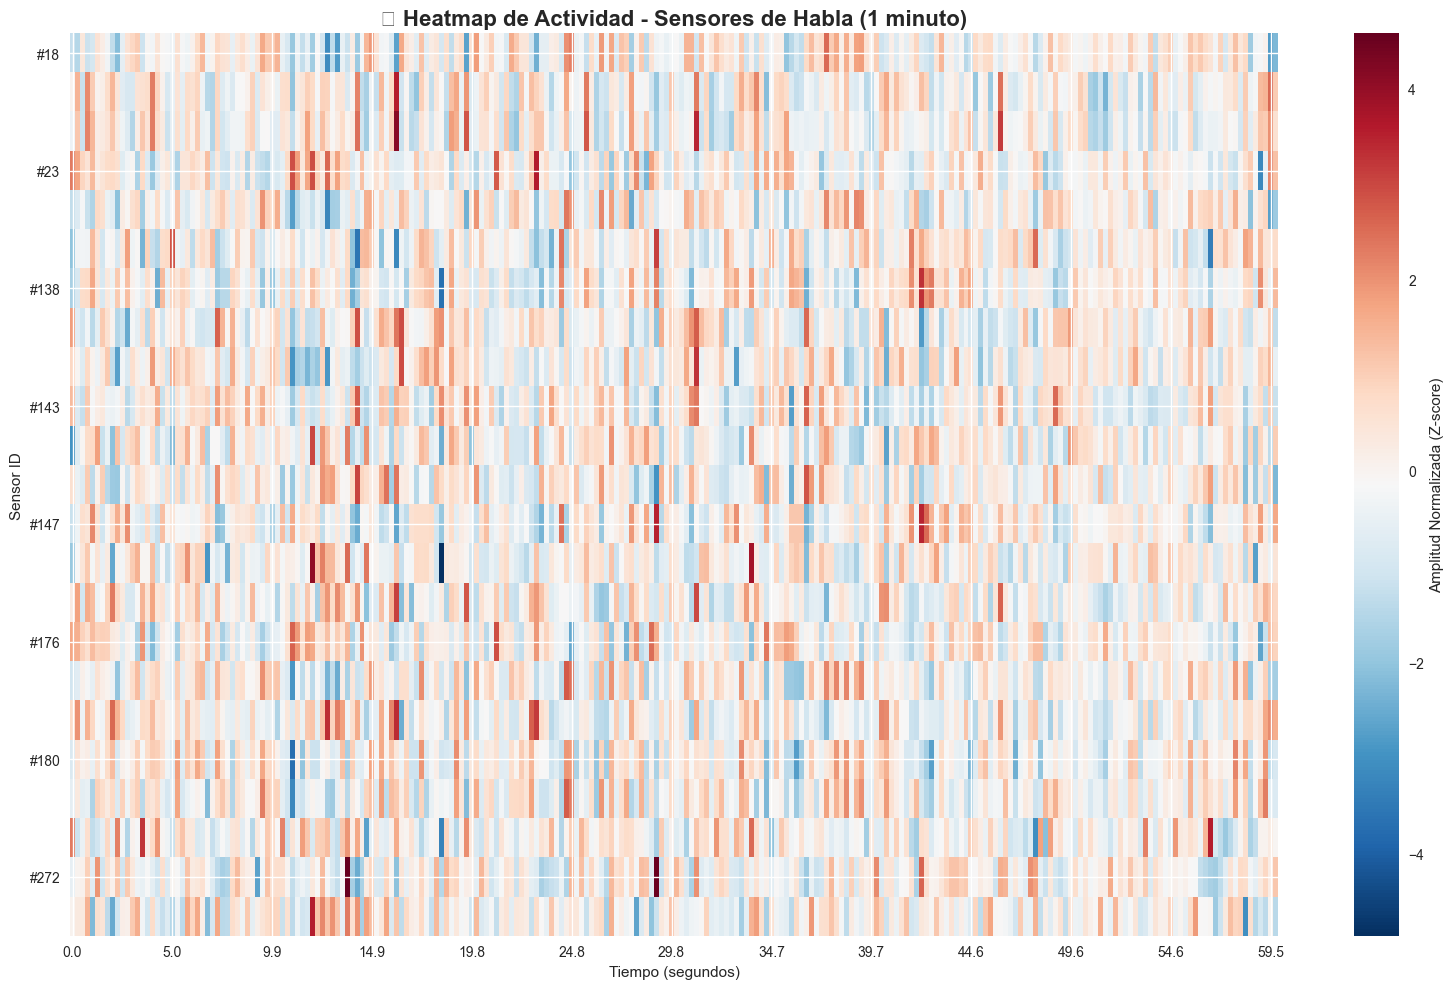

📊 Heatmap muestra 23 sensores durante 60.0 segundos
⏱️ Resolución temporal: 242 puntos (16 ms por punto)


In [11]:
# Heatmap de actividad de sensores importantes
print("🎨 Creando heatmap de actividad de sensores de habla...")

# Tomar una muestra cada 250 muestras (cada segundo) para visualización
time_subsample = np.arange(0, meg_1min.shape[1], SFREQ//4)  # Cada 0.25 segundos
meg_subsample = meg_1min[SPEECH_SENSORS, :][:, time_subsample]
times_subsample = times_1min[time_subsample]

# Normalizar por sensor para mejor visualización
meg_normalized = (meg_subsample - meg_subsample.mean(axis=1, keepdims=True)) / meg_subsample.std(axis=1, keepdims=True)

# Crear heatmap
plt.figure(figsize=(16, 10))
im = plt.imshow(meg_normalized, aspect='auto', cmap='RdBu_r', interpolation='nearest')
plt.colorbar(im, label='Amplitud Normalizada (Z-score)')
plt.title('🔥 Heatmap de Actividad - Sensores de Habla (1 minuto)', fontsize=16, fontweight='bold')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Sensor ID')

# Configurar etiquetas de tiempo
time_ticks = np.arange(0, len(times_subsample), len(times_subsample)//12)  # 12 ticks
plt.xticks(time_ticks, [f"{times_subsample[i]:.1f}" for i in time_ticks])

# Configurar etiquetas de sensores
sensor_ticks = np.arange(0, len(SPEECH_SENSORS), 3)
plt.yticks(sensor_ticks, [f"#{SPEECH_SENSORS[i]}" for i in sensor_ticks])

plt.tight_layout()
plt.show()

print(f"📊 Heatmap muestra {len(SPEECH_SENSORS)} sensores durante {times_1min[-1]:.1f} segundos")
print(f"⏱️ Resolución temporal: {len(time_subsample)} puntos ({1000//(SFREQ//4)} ms por punto)")

## 🌊 Análisis de Frecuencias

Analicemos el contenido frecuencial de las señales MEG para identificar patrones característicos.

🌊 Realizando análisis de frecuencias...
🔄 Calculando rangos de potencia...
📊 Rango de potencia: -44.1 a -13.5 dB


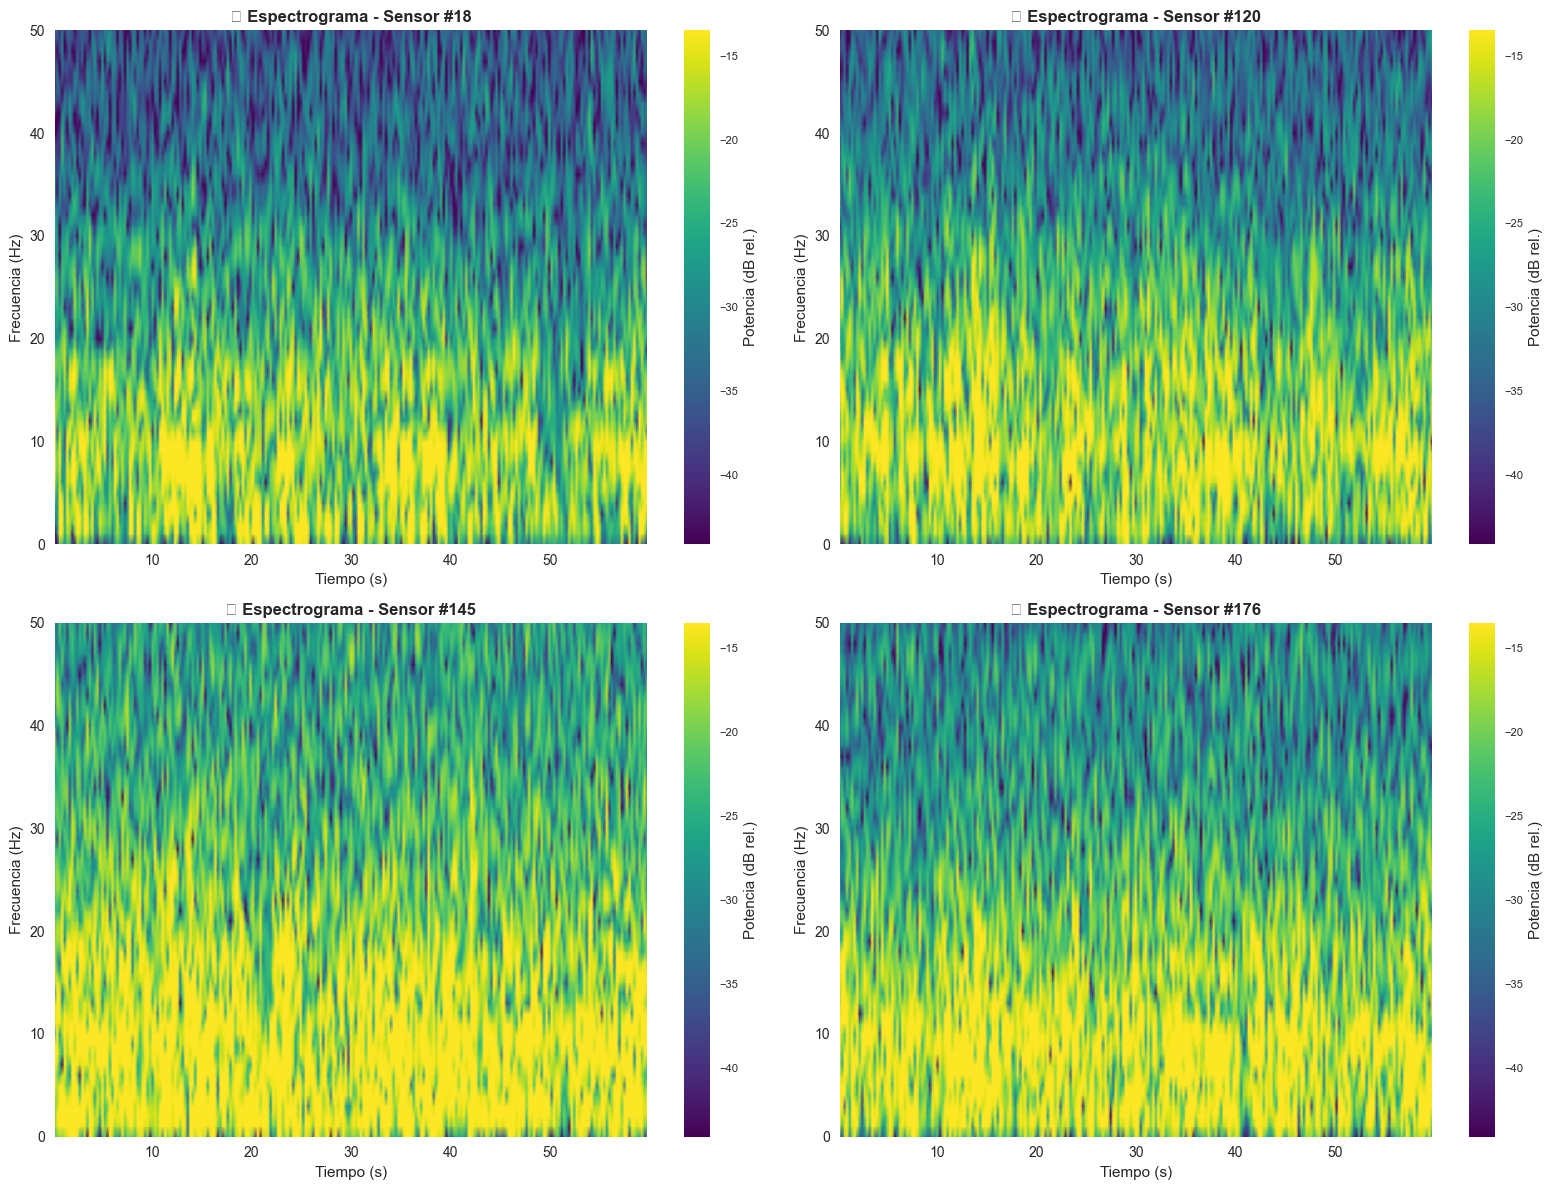

📈 Espectrogramas calculados para 4 sensores
🎯 Frecuencias analizadas: 0-50 Hz (relevantes para actividad neural)
⏱️ Resolución temporal: 3950 ms por punto
🔍 Resolución frecuencial: 1.00 Hz
📊 Rango dinámico: 30.6 dB


In [16]:
# Análisis espectral mejorado
print("🌊 Realizando análisis de frecuencias...")

# Seleccionar algunos sensores representativos para análisis detallado
selected_sensors = [SPEECH_SENSORS[0], SPEECH_SENSORS[5], SPEECH_SENSORS[10], SPEECH_SENSORS[15]]
sensor_names = [f"Sensor #{s}" for s in selected_sensors]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Calcular rangos globales para consistencia visual
all_Sxx_db = []

# Primer paso: calcular todos los espectrogramas para obtener rangos
print("🔄 Calculando rangos de potencia...")
for sensor_idx in selected_sensors:
    # Parámetros optimizados para MEG
    frequencies, times_spec, Sxx = signal.spectrogram(
        meg_1min[sensor_idx, :], 
        fs=SFREQ, 
        window='hann',
        nperseg=SFREQ//2,  # 0.5 segundos de ventana (mejor resolución temporal)
        noverlap=SFREQ//4,  # 50% de overlap
        nfft=SFREQ  # 1 segundo de FFT
    )
    
    # Normalizar y convertir a dB
    Sxx_norm = Sxx / np.max(Sxx)  # Normalizar por el máximo
    Sxx_db = 10 * np.log10(Sxx_norm + 1e-10)
    all_Sxx_db.append(Sxx_db)

# Calcular percentiles para mejor visualización
all_values = np.concatenate([spec.flatten() for spec in all_Sxx_db])
vmin = np.percentile(all_values, 5)   # Percentil 5
vmax = np.percentile(all_values, 95)  # Percentil 95

print(f"📊 Rango de potencia: {vmin:.1f} a {vmax:.1f} dB")

# Segundo paso: crear las visualizaciones
for i, (sensor_idx, Sxx_db) in enumerate(zip(selected_sensors, all_Sxx_db)):
    # Recalcular para obtener times_spec y frequencies
    frequencies, times_spec, _ = signal.spectrogram(
        meg_1min[sensor_idx, :], 
        fs=SFREQ, 
        window='hann',
        nperseg=SFREQ//2,
        noverlap=SFREQ//4,
        nfft=SFREQ
    )
    
    # Plotear con rangos consistentes
    im = axes[i].pcolormesh(times_spec, frequencies, Sxx_db, 
                           shading='gouraud', cmap='viridis',
                           vmin=vmin, vmax=vmax)
    
    axes[i].set_title(f'📊 Espectrograma - {sensor_names[i]}', fontweight='bold')
    axes[i].set_xlabel('Tiempo (s)')
    axes[i].set_ylabel('Frecuencia (Hz)')
    axes[i].set_ylim(0, 50)  # Enfocar en frecuencias bajas relevantes
    axes[i].grid(True, alpha=0.3)
    
    # Agregar colorbar individual
    cbar = plt.colorbar(im, ax=axes[i], label='Potencia (dB rel.)')
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# Información adicional sobre el análisis
print(f"📈 Espectrogramas calculados para {len(selected_sensors)} sensores")
print(f"🎯 Frecuencias analizadas: 0-50 Hz (relevantes para actividad neural)")
print(f"⏱️ Resolución temporal: {1000*len(times_spec)/60:.0f} ms por punto")
print(f"🔍 Resolución frecuencial: {frequencies[1]-frequencies[0]:.2f} Hz")
print(f"📊 Rango dinámico: {vmax-vmin:.1f} dB")

🧠 Analizando bandas de frecuencia cerebrales...


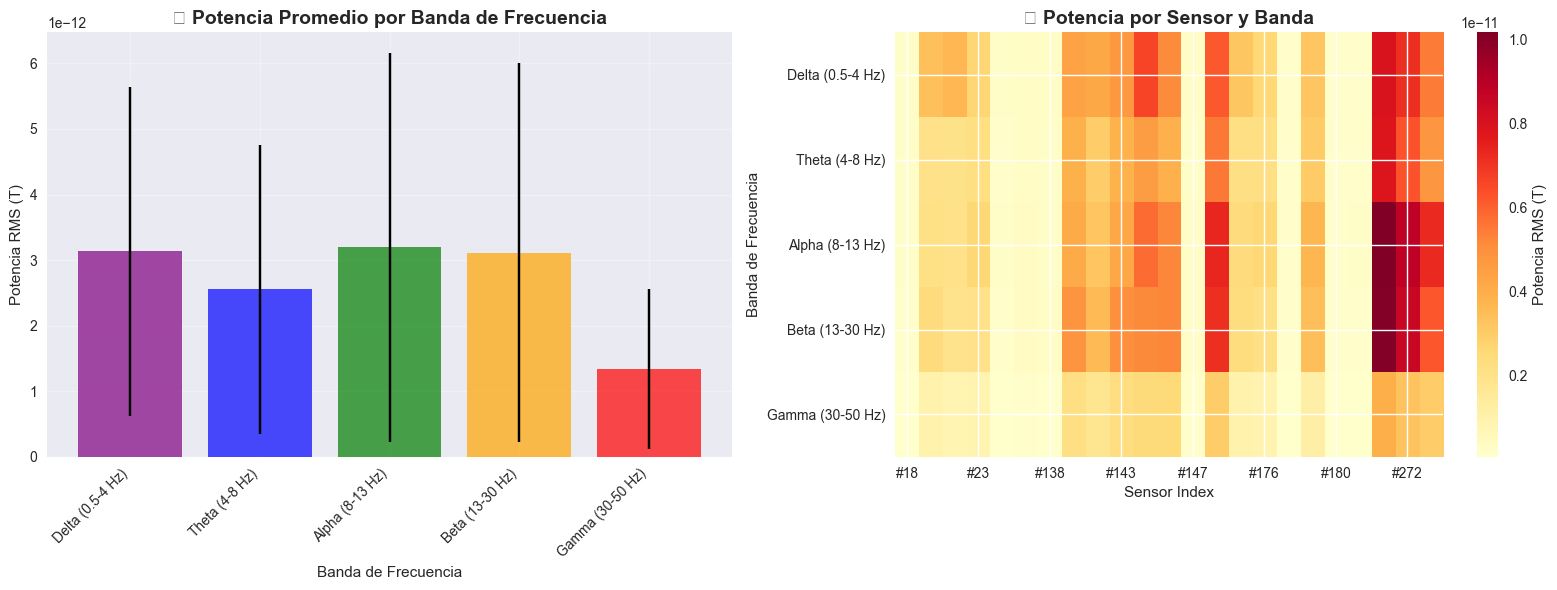

🏆 Banda más activa: Alpha (8-13 Hz)
💪 Potencia promedio: 3.20e-12 T


In [17]:
# Análisis de bandas de frecuencia cerebrales
print("🧠 Analizando bandas de frecuencia cerebrales...")

# Definir bandas de frecuencia importantes en neurociencia
freq_bands = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-50 Hz)': (30, 50)
}

# Calcular potencia en cada banda para sensores de habla
band_powers = {}
for band_name, (low_freq, high_freq) in freq_bands.items():
    # Filtrar señal en la banda
    sos = signal.butter(4, [low_freq, high_freq], btype='band', fs=SFREQ, output='sos')
    filtered_signals = signal.sosfilt(sos, meg_1min[SPEECH_SENSORS, :], axis=1)
    
    # Calcular potencia (RMS)
    power = np.sqrt(np.mean(filtered_signals**2, axis=1))
    band_powers[band_name] = power

# Visualizar potencias por banda
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras promedio
band_names = list(freq_bands.keys())
avg_powers = [np.mean(band_powers[band]) for band in band_names]
std_powers = [np.std(band_powers[band]) for band in band_names]

ax1.bar(range(len(band_names)), avg_powers, yerr=std_powers, 
        capsize=5, alpha=0.7, color=['purple', 'blue', 'green', 'orange', 'red'])
ax1.set_title('🎵 Potencia Promedio por Banda de Frecuencia', fontweight='bold', fontsize=14)
ax1.set_xlabel('Banda de Frecuencia')
ax1.set_ylabel('Potencia RMS (T)')
ax1.set_xticks(range(len(band_names)))
ax1.set_xticklabels(band_names, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Heatmap de potencias por sensor y banda
power_matrix = np.array([band_powers[band] for band in band_names])
im = ax2.imshow(power_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_title('🔥 Potencia por Sensor y Banda', fontweight='bold', fontsize=14)
ax2.set_xlabel('Sensor Index')
ax2.set_ylabel('Banda de Frecuencia')
ax2.set_yticks(range(len(band_names)))
ax2.set_yticklabels(band_names)
plt.colorbar(im, ax=ax2, label='Potencia RMS (T)')

# Mostrar solo algunos sensores en el eje x
sensor_indices = np.arange(0, len(SPEECH_SENSORS), 3)
ax2.set_xticks(sensor_indices)
ax2.set_xticklabels([f"#{SPEECH_SENSORS[i]}" for i in sensor_indices])

plt.tight_layout()
plt.show()

# Encontrar banda más activa
max_band = max(band_names, key=lambda x: np.mean(band_powers[x]))
print(f"🏆 Banda más activa: {max_band}")
print(f"💪 Potencia promedio: {np.mean(band_powers[max_band]):.2e} T")

## 🔗 Análisis de Conectividad entre Sensores

Examinemos cómo se correlacionan los diferentes sensores entre sí para entender la conectividad funcional.

🔗 Calculando correlaciones entre sensores...


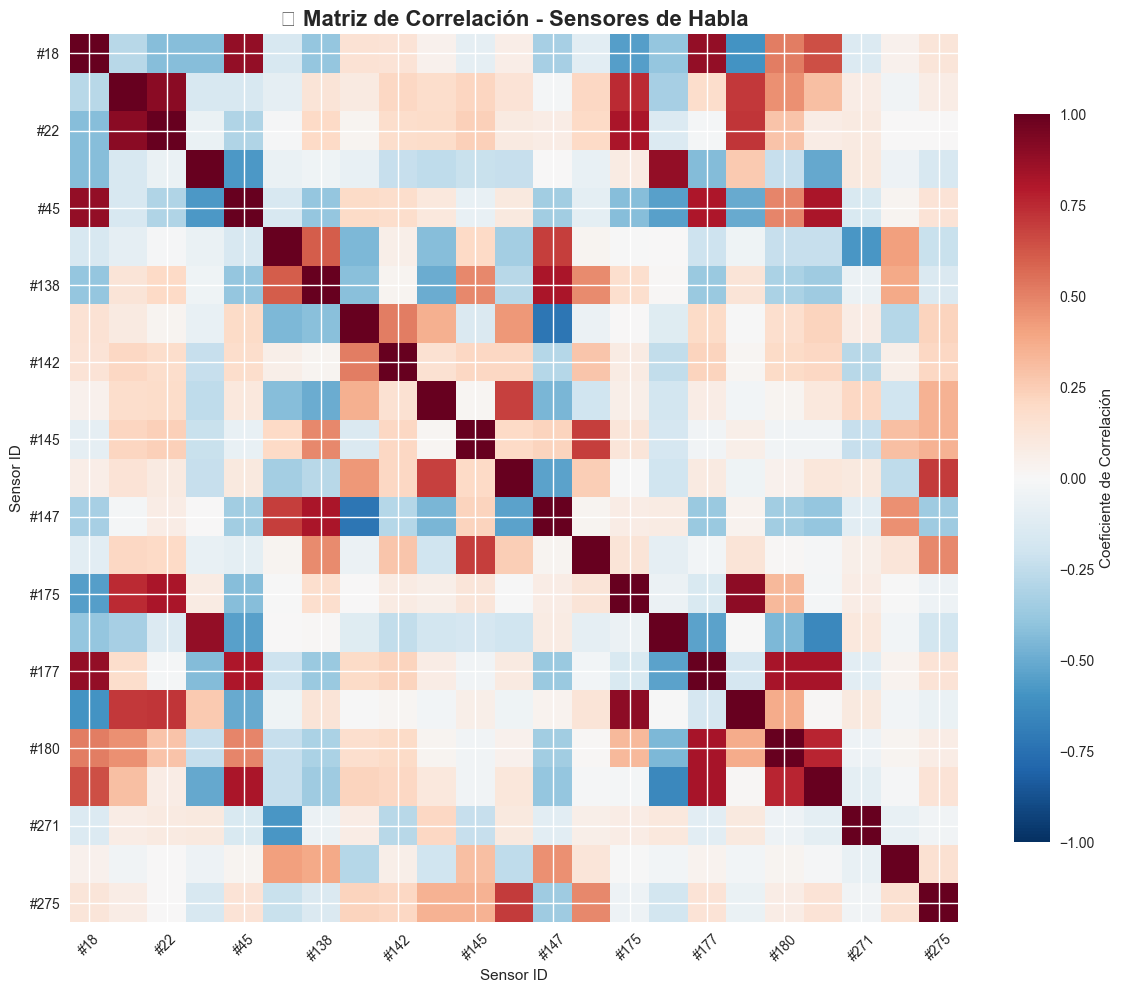


📊 ESTADÍSTICAS DE CORRELACIÓN:
   Correlación promedio:    0.038
   Correlación máxima:      0.899
   Correlación mínima:      -0.723
   Desviación estándar:     0.324

🏆 Par más correlacionado:
   Sensores #22 y #20
   Correlación: 0.899

🔻 Par menos correlacionado:
   Sensores #140 y #147
   Correlación: -0.723


In [13]:
# Análisis de conectividad entre sensores
print("🔗 Calculando correlaciones entre sensores...")

# Calcular matriz de correlación para sensores de habla
speech_data = meg_1min[SPEECH_SENSORS, :]
correlation_matrix = np.corrcoef(speech_data)

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara triangular superior

# Crear heatmap
im = plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar(im, label='Coeficiente de Correlación', shrink=0.8)
plt.title('🔗 Matriz de Correlación - Sensores de Habla', fontsize=16, fontweight='bold')

# Configurar etiquetas
sensor_labels = [f"#{s}" for s in SPEECH_SENSORS]
tick_positions = np.arange(0, len(SPEECH_SENSORS), 2)  # Mostrar cada 2 sensores
plt.xticks(tick_positions, [sensor_labels[i] for i in tick_positions], rotation=45)
plt.yticks(tick_positions, [sensor_labels[i] for i in tick_positions])
plt.xlabel('Sensor ID')
plt.ylabel('Sensor ID')

plt.tight_layout()
plt.show()

# Estadísticas de correlación
correlation_values = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]
print(f"\n📊 ESTADÍSTICAS DE CORRELACIÓN:")
print(f"   Correlación promedio:    {np.mean(correlation_values):.3f}")
print(f"   Correlación máxima:      {np.max(correlation_values):.3f}")
print(f"   Correlación mínima:      {np.min(correlation_values):.3f}")
print(f"   Desviación estándar:     {np.std(correlation_values):.3f}")

# Encontrar pares más correlacionados
max_corr_idx = np.unravel_index(np.argmax(correlation_matrix - np.eye(len(SPEECH_SENSORS))), 
                                correlation_matrix.shape)
min_corr_idx = np.unravel_index(np.argmin(correlation_matrix), correlation_matrix.shape)

print(f"\n🏆 Par más correlacionado:")
print(f"   Sensores #{SPEECH_SENSORS[max_corr_idx[0]]} y #{SPEECH_SENSORS[max_corr_idx[1]]}")
print(f"   Correlación: {correlation_matrix[max_corr_idx]:.3f}")

print(f"\n🔻 Par menos correlacionado:")
print(f"   Sensores #{SPEECH_SENSORS[min_corr_idx[0]]} y #{SPEECH_SENSORS[min_corr_idx[1]]}")
print(f"   Correlación: {correlation_matrix[min_corr_idx]:.3f}")

In [14]:
# Visualización 3D interactiva de sensores
print("🎯 Creando visualización 3D de sensores...")

# Calcular actividad promedio para colorear sensores
sensor_activity = np.sqrt(np.mean(meg_1min**2, axis=1))  # RMS como medida de actividad

# Crear figura 3D interactiva
fig = go.Figure()

# Agregar todos los sensores (en gris claro)
fig.add_trace(go.Scatter3d(
    x=sensor_xyz[:, 0],
    y=sensor_xyz[:, 1], 
    z=sensor_xyz[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color='lightgray',
        opacity=0.3
    ),
    name='Otros sensores',
    hovertemplate='Sensor %{text}<br>Actividad: %{marker.color:.2e}<extra></extra>',
    text=[f"#{i}" for i in range(len(sensor_xyz))]
))

# Agregar sensores de habla (destacados)
speech_positions = sensor_xyz[SPEECH_SENSORS]
speech_activity = sensor_activity[SPEECH_SENSORS]

fig.add_trace(go.Scatter3d(
    x=speech_positions[:, 0],
    y=speech_positions[:, 1],
    z=speech_positions[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color=speech_activity,
        colorscale='Viridis',
        colorbar=dict(title="Actividad RMS (T)", x=1.1),
        cmin=speech_activity.min(),
        cmax=speech_activity.max(),
        opacity=0.8
    ),
    name='Sensores de habla',
    hovertemplate='Sensor #%{text}<br>Actividad: %{marker.color:.2e}<br>Posición: (%{x:.1f}, %{y:.1f}, %{z:.1f})<extra></extra>',
    text=[str(s) for s in SPEECH_SENSORS]
))

# Configurar diseño
fig.update_layout(
    title={
        'text': '🧠 Distribución 3D de Sensores MEG - Muestra de 1 Minuto',
        'x': 0.5,
        'font': {'size': 16}
    },
    scene=dict(
        xaxis_title='X (mm)',
        yaxis_title='Y (mm)', 
        zaxis_title='Z (mm)',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='cube'
    ),
    width=800,
    height=600,
    showlegend=True
)

fig.show()

print(f"🎯 Visualización 3D creada con {len(sensor_xyz)} sensores totales")
print(f"🗣️ {len(SPEECH_SENSORS)} sensores de habla destacados en color")
print(f"📊 Color representa actividad RMS durante el minuto analizado")

🎯 Creando visualización 3D de sensores...


🎯 Visualización 3D creada con 306 sensores totales
🗣️ 23 sensores de habla destacados en color
📊 Color representa actividad RMS durante el minuto analizado


## 🆚 Comparación: Habla vs Silencio

Ahora analicemos las diferencias entre periodos de habla y silencio para entender mejor qué patrones distinguen estos estados cerebrales.

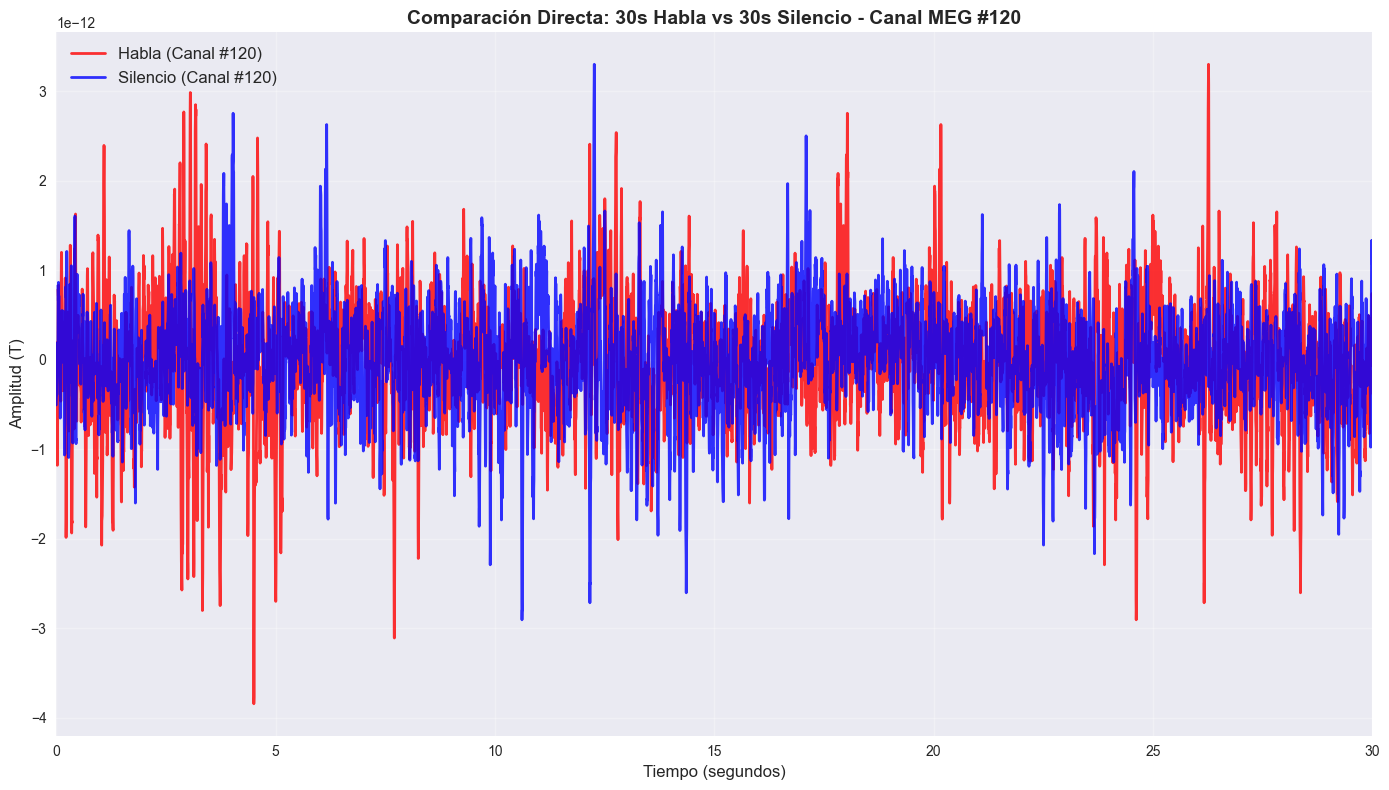

🔄 Calculando espectro de potencia para ambos segmentos (1-200 Hz)...


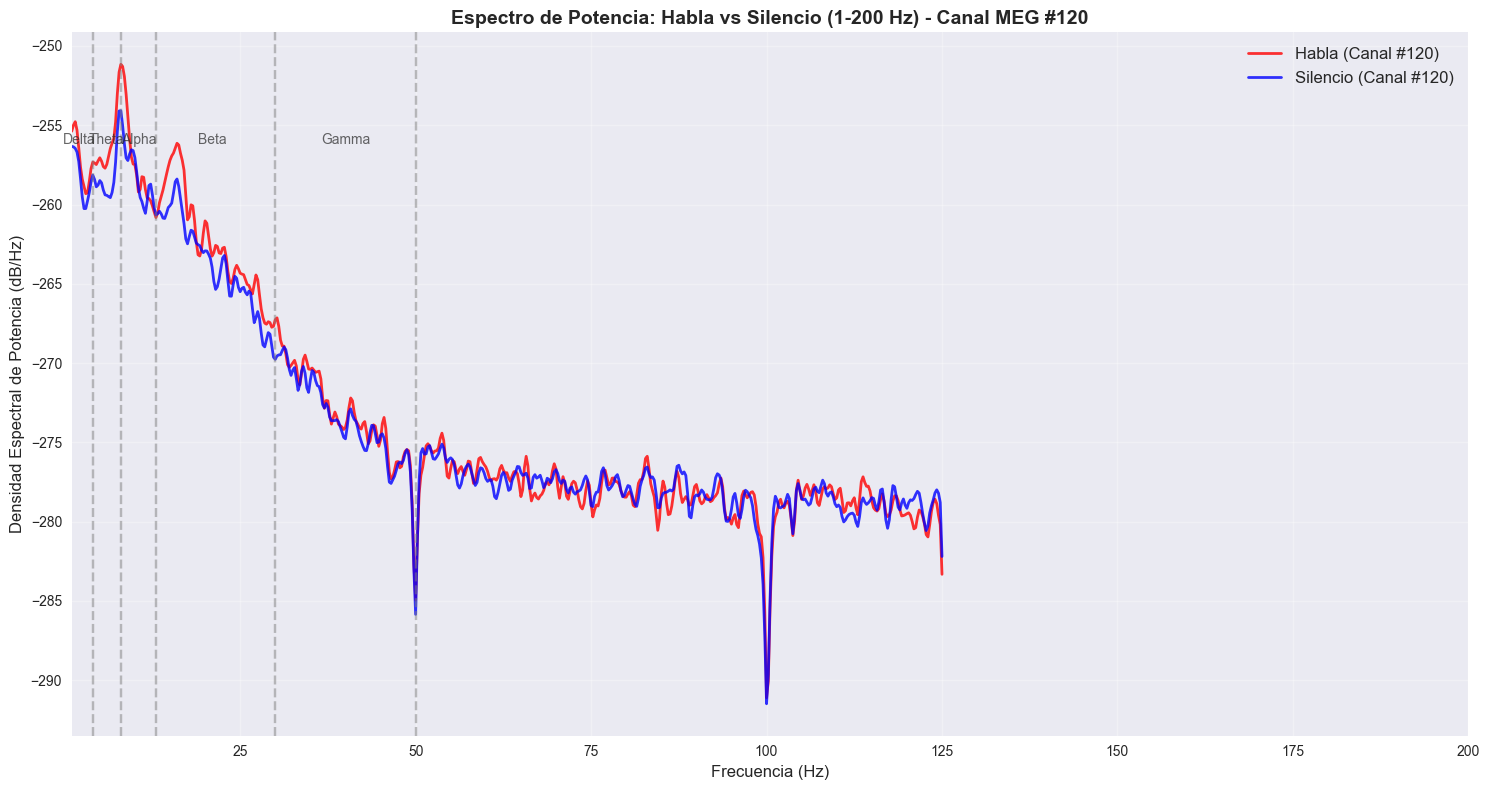

📊 Espectro calculado para frecuencias de 1 a 200 Hz
📈 Resolución frecuencial: 0.250 Hz
🎯 Rango de potencia Habla: -291.1 a -251.2 dB/Hz
🎯 Rango de potencia Silencio: -291.5 a -254.1 dB/Hz


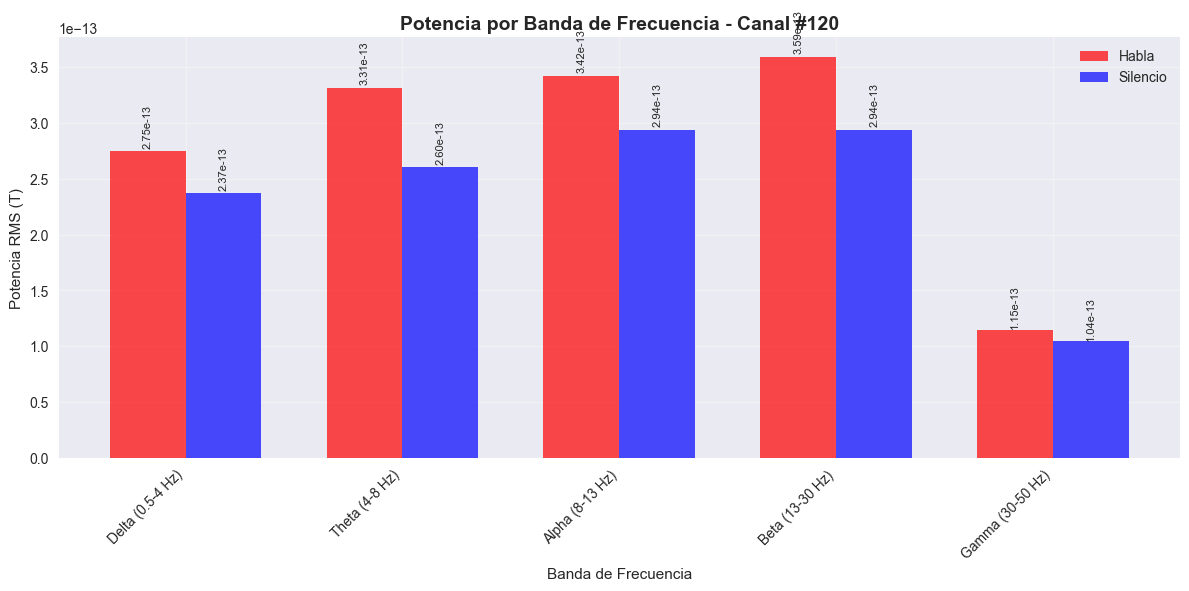

In [45]:
# Comparación directa: 30 segundos de Habla vs 30 segundos de Silencio
COMPARISON_DURATION = 30.0  # segundos
comparison_samples = int(COMPARISON_DURATION * SFREQ)

# Seleccionar un canal representativo de habla para la comparación
selected_channel = SPEECH_SENSORS[5]  # Canal del medio de los sensores de habla

# Calcular actividad promedio en ventanas deslizantes para encontrar los mejores segmentos
window_size = comparison_samples
activity_per_window = []
window_starts = []

for start in range(0, len(times_1min) - window_size, SFREQ):  # Paso de 1 segundo
    window_activity = np.std(meg_1min[selected_channel, start:start + window_size])
    activity_per_window.append(window_activity)
    window_starts.append(start)

activity_per_window = np.array(activity_per_window)
window_starts = np.array(window_starts)

# Encontrar el segmento más activo (habla) y menos activo (silencio)
speech_idx = np.argmax(activity_per_window)
silence_idx = np.argmin(activity_per_window)

speech_start = window_starts[speech_idx]
silence_start = window_starts[silence_idx]

# Extraer los segmentos de 30 segundos
speech_segment_30s = meg_1min[selected_channel, speech_start:speech_start + comparison_samples]
silence_segment_30s = meg_1min[selected_channel, silence_start:silence_start + comparison_samples]

# Crear vector de tiempo
times_30s = np.linspace(0, COMPARISON_DURATION, comparison_samples)

# VISUALIZACIÓN: Un solo gráfico limpio con ambas señales superpuestas
plt.figure(figsize=(14, 8))

# Plotear ambas señales superpuestas
plt.plot(times_30s, speech_segment_30s, 'r-', linewidth=2, alpha=0.8, label=f'Habla (Canal #{selected_channel})')
plt.plot(times_30s, silence_segment_30s, 'b-', linewidth=2, alpha=0.8, label=f'Silencio (Canal #{selected_channel})')

# Configuración del gráfico
plt.xlabel('Tiempo (segundos)', fontsize=12)
plt.ylabel('Amplitud (T)', fontsize=12)
plt.title(f'Comparación Directa: 30s Habla vs 30s Silencio - Canal MEG #{selected_channel}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)

plt.tight_layout()
plt.show()

# ANÁLISIS DE FRECUENCIAS: Espectro de potencia 1-200 Hz
print("🔄 Calculando espectro de potencia para ambos segmentos (1-200 Hz)...")

# Usar Welch's method para un espectro más robusto
from scipy.signal import welch

# Calcular densidad espectral de potencia usando método de Welch
freq_speech, psd_speech = welch(speech_segment_30s, fs=SFREQ, nperseg=SFREQ*2, 
                                noverlap=SFREQ, nfft=SFREQ*4)
freq_silence, psd_silence = welch(silence_segment_30s, fs=SFREQ, nperseg=SFREQ*2, 
                                  noverlap=SFREQ, nfft=SFREQ*4)

# Filtrar frecuencias en el rango 1-200 Hz
freq_mask = (freq_speech >= 1) & (freq_speech <= 200)
freq_range = freq_speech[freq_mask]
psd_speech_range = psd_speech[freq_mask]
psd_silence_range = psd_silence[freq_mask]

# Convertir a dB (densidad espectral de potencia)
psd_speech_db = 10 * np.log10(psd_speech_range)
psd_silence_db = 10 * np.log10(psd_silence_range)

# Crear gráfico de espectro de potencia
plt.figure(figsize=(15, 8))

plt.plot(freq_range, psd_speech_db, 'r-', linewidth=2, alpha=0.8, label=f'Habla (Canal #{selected_channel})')
plt.plot(freq_range, psd_silence_db, 'b-', linewidth=2, alpha=0.8, label=f'Silencio (Canal #{selected_channel})')

plt.xlabel('Frecuencia (Hz)', fontsize=12)
plt.ylabel('Densidad Espectral de Potencia (dB/Hz)', fontsize=12)
plt.title(f'Espectro de Potencia: Habla vs Silencio (1-200 Hz) - Canal MEG #{selected_channel}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(1, 200)

# Agregar líneas verticales para marcar bandas importantes
plt.axvline(x=4, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

# Agregar etiquetas de bandas
plt.text(2, max(psd_speech_db.max(), psd_silence_db.max())-5, 'Delta', ha='center', fontsize=10, alpha=0.7)
plt.text(6, max(psd_speech_db.max(), psd_silence_db.max())-5, 'Theta', ha='center', fontsize=10, alpha=0.7)
plt.text(10.5, max(psd_speech_db.max(), psd_silence_db.max())-5, 'Alpha', ha='center', fontsize=10, alpha=0.7)
plt.text(21, max(psd_speech_db.max(), psd_silence_db.max())-5, 'Beta', ha='center', fontsize=10, alpha=0.7)
plt.text(40, max(psd_speech_db.max(), psd_silence_db.max())-5, 'Gamma', ha='center', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"📊 Espectro calculado para frecuencias de 1 a 200 Hz")
print(f"📈 Resolución frecuencial: {freq_range[1]-freq_range[0]:.3f} Hz")
print(f"🎯 Rango de potencia Habla: {psd_speech_db.min():.1f} a {psd_speech_db.max():.1f} dB/Hz")
print(f"🎯 Rango de potencia Silencio: {psd_silence_db.min():.1f} a {psd_silence_db.max():.1f} dB/Hz")

# Análisis de potencia por bandas de frecuencia
freq_bands_analysis = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-50 Hz)': (30, 50)
}

# Calcular potencia en cada banda para ambos segmentos
speech_band_powers = {}
silence_band_powers = {}

for band_name, (low_freq, high_freq) in freq_bands_analysis.items():
    # Filtrar señales en la banda
    sos = signal.butter(4, [low_freq, high_freq], btype='band', fs=SFREQ, output='sos')
    speech_filtered = signal.sosfilt(sos, speech_segment_30s)
    silence_filtered = signal.sosfilt(sos, silence_segment_30s)
    
    # Calcular potencia RMS
    speech_power = np.sqrt(np.mean(speech_filtered**2))
    silence_power = np.sqrt(np.mean(silence_filtered**2))
    
    speech_band_powers[band_name] = speech_power
    silence_band_powers[band_name] = silence_power

# Visualizar comparación de potencias por banda
fig, ax = plt.subplots(figsize=(12, 6))

band_names = list(freq_bands_analysis.keys())
speech_powers = [speech_band_powers[band] for band in band_names]
silence_powers = [silence_band_powers[band] for band in band_names]

x_pos = np.arange(len(band_names))
width = 0.35

bars1 = ax.bar(x_pos - width/2, speech_powers, width, label='Habla', color='red', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, silence_powers, width, label='Silencio', color='blue', alpha=0.7)

ax.set_title(f'Potencia por Banda de Frecuencia - Canal #{selected_channel}', fontweight='bold', fontsize=14)
ax.set_xlabel('Banda de Frecuencia')
ax.set_ylabel('Potencia RMS (T)')
ax.set_xticks(x_pos)
ax.set_xticklabels(band_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Agregar valores en las barras
for i, (speech_val, silence_val) in enumerate(zip(speech_powers, silence_powers)):
    ax.text(i - width/2, speech_val + speech_val*0.01, f'{speech_val:.2e}', 
            ha='center', va='bottom', fontsize=8, rotation=90)
    ax.text(i + width/2, silence_val + silence_val*0.01, f'{silence_val:.2e}', 
            ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

🔬 Análisis ultra-corto: 0.1 segundos (25 muestras)
🎯 Canal seleccionado: #120
🔄 Calculando potencia por bandas para segmentos ultra-cortos...
📊 Bandas analizadas: 10
📈 Resolución frecuencial: 10.00 Hz


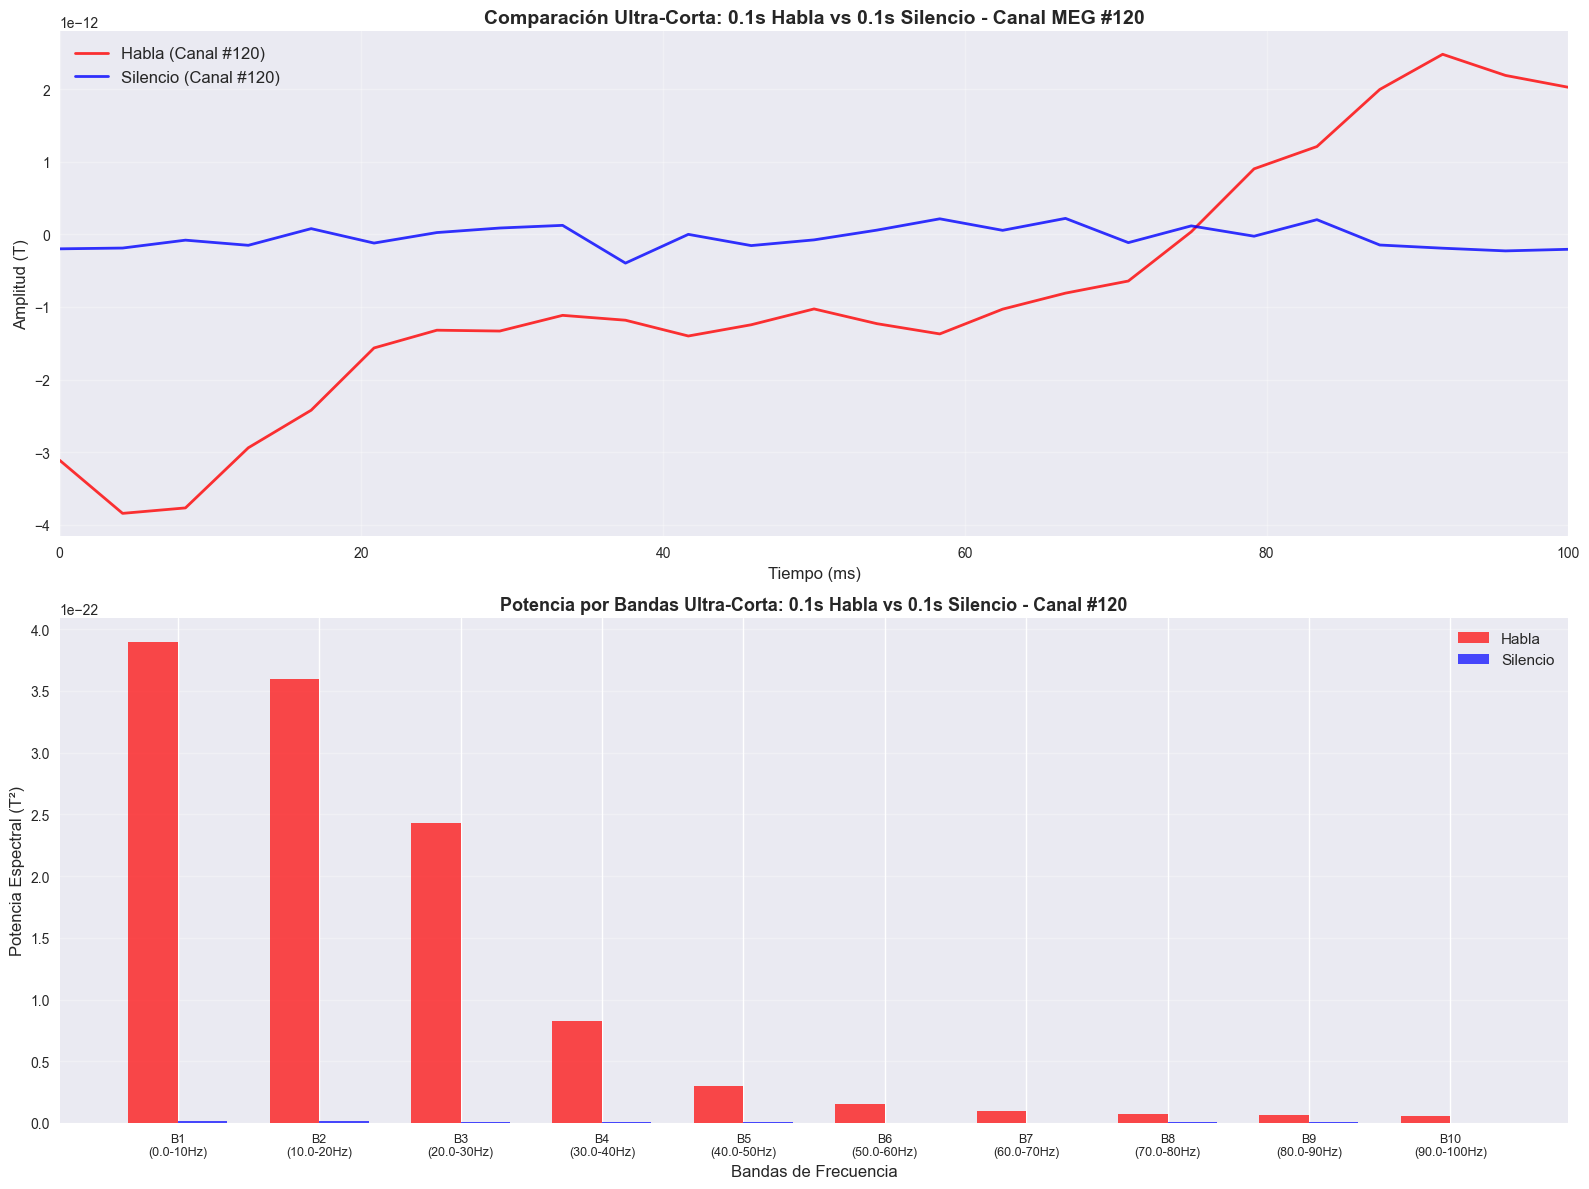

📊 Análisis ultra-corto completado:
   Duración: 100 ms (25 muestras)
   Habla - Inicio: 15.50s, Actividad: 1.75e-12
   Silencio - Inicio: 20.00s, Actividad: 1.56e-13
   Ratio de actividad: 11.20

🎵 Potencia por bandas:
   Band 1 (0-10 Hz): Habla=3.90e-22, Silencio=1.33e-24, Ratio=292.62
   Band 2 (10-20 Hz): Habla=3.60e-22, Silencio=1.59e-24, Ratio=226.72
   Band 3 (20-30 Hz): Habla=2.43e-22, Silencio=9.92e-25, Ratio=244.98
   Band 4 (30-40 Hz): Habla=8.28e-23, Silencio=4.69e-25, Ratio=176.69
   Band 5 (40-50 Hz): Habla=2.95e-23, Silencio=3.48e-25, Ratio=84.96
   Band 6 (50-60 Hz): Habla=1.53e-23, Silencio=2.12e-25, Ratio=72.14
   Band 7 (60-70 Hz): Habla=9.43e-24, Silencio=2.52e-25, Ratio=37.44
   Band 8 (70-80 Hz): Habla=7.15e-24, Silencio=3.68e-25, Ratio=19.42
   Band 9 (80-90 Hz): Habla=6.48e-24, Silencio=4.60e-25, Ratio=14.08
   Band 10 (90-100 Hz): Habla=5.71e-24, Silencio=2.34e-25, Ratio=24.42


In [54]:
# Análisis ultra-corto: 0.1 segundos de Habla vs 0.1 segundos de Silencio
ULTRA_SHORT_DURATION = 0.1  # segundos (100 ms)
ultra_short_samples = int(ULTRA_SHORT_DURATION * SFREQ)

print(f"🔬 Análisis ultra-corto: {ULTRA_SHORT_DURATION} segundos ({ultra_short_samples} muestras)")
print(f"🎯 Canal seleccionado: #{selected_channel}")

# Calcular actividad en ventanas ultra-cortas
ultra_window_size = ultra_short_samples
ultra_activity_per_window = []
ultra_window_starts = []

for start in range(0, len(times_1min) - ultra_window_size, SFREQ//10):  # Paso de 0.1 segundos
    window_activity = np.std(meg_1min[selected_channel, start:start + ultra_window_size])
    ultra_activity_per_window.append(window_activity)
    ultra_window_starts.append(start)

ultra_activity_per_window = np.array(ultra_activity_per_window)
ultra_window_starts = np.array(ultra_window_starts)

# Encontrar el segmento más activo (habla) y menos activo (silencio)
ultra_speech_idx = np.argmax(ultra_activity_per_window)
ultra_silence_idx = np.argmin(ultra_activity_per_window)

ultra_speech_start = ultra_window_starts[ultra_speech_idx]
ultra_silence_start = ultra_window_starts[ultra_silence_idx]

# Extraer los segmentos de 0.1 segundos
ultra_speech_segment = meg_1min[selected_channel, ultra_speech_start:ultra_speech_start + ultra_short_samples]
ultra_silence_segment = meg_1min[selected_channel, ultra_silence_start:ultra_silence_start + ultra_short_samples]

# Crear vector de tiempo en milisegundos para mejor visualización
times_ultra_ms = np.linspace(0, ULTRA_SHORT_DURATION * 1000, ultra_short_samples)

# VISUALIZACIÓN: Señales ultra-cortas superpuestas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))  # Aumentar altura para acomodar más bandas

# Gráfico temporal
ax1.plot(times_ultra_ms, ultra_speech_segment, 'r-', linewidth=2, alpha=0.8, 
         label=f'Habla (Canal #{selected_channel})')
ax1.plot(times_ultra_ms, ultra_silence_segment, 'b-', linewidth=2, alpha=0.8, 
         label=f'Silencio (Canal #{selected_channel})')

ax1.set_xlabel('Tiempo (ms)', fontsize=12)
ax1.set_ylabel('Amplitud (T)', fontsize=12)
ax1.set_title(f'Comparación Ultra-Corta: 0.1s Habla vs 0.1s Silencio - Canal MEG #{selected_channel}', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 100)

# ANÁLISIS DE BANDAS DE FRECUENCIA para segmentos ultra-cortos
print("🔄 Calculando potencia por bandas para segmentos ultra-cortos...")

# Para señales muy cortas, usar FFT directo con ventana más apropiada
from scipy.fft import fft, fftfreq

# Calcular FFT directo para ambos segmentos
fft_speech = np.abs(fft(ultra_speech_segment))
fft_silence = np.abs(fft(ultra_silence_segment))
freqs = fftfreq(len(ultra_speech_segment), 1/SFREQ)

# Tomar solo las frecuencias positivas
positive_freq_mask = freqs >= 0
freqs_positive = freqs[positive_freq_mask]
fft_speech_positive = fft_speech[positive_freq_mask]
fft_silence_positive = fft_silence[positive_freq_mask]

# Definir bandas de frecuencia adaptadas a la resolución disponible (10 Hz)
# Para segmentos de 0.1s, la resolución frecuencial es de 10 Hz
bands_ultra = {
    'Band 1 (0-10 Hz)': (0, 10),
    'Band 2 (10-20 Hz)': (10, 20), 
    'Band 3 (20-30 Hz)': (20, 30),
    'Band 4 (30-40 Hz)': (30, 40),
    'Band 5 (40-50 Hz)': (40, 50),
    'Band 6 (50-60 Hz)': (50, 60),
    'Band 7 (60-70 Hz)': (60, 70),
    'Band 8 (70-80 Hz)': (70, 80),
    'Band 9 (80-90 Hz)': (80, 90),
    'Band 10 (90-100 Hz)': (90, 100)
}

# Calcular potencia por bandas usando FFT
band_powers_speech_ultra = []
band_powers_silence_ultra = []
band_names_ultra = []

for band_name, (low_freq, high_freq) in bands_ultra.items():
    # Encontrar índices de frecuencia para cada banda
    freq_mask = (freqs_positive >= low_freq) & (freqs_positive <= high_freq)
    
    if np.any(freq_mask):  # Solo si hay frecuencias en la banda
        # Calcular potencia promedio en la banda (potencia espectral)
        power_speech = np.mean(fft_speech_positive[freq_mask]**2)
        power_silence = np.mean(fft_silence_positive[freq_mask]**2)
        
        band_powers_speech_ultra.append(power_speech)
        band_powers_silence_ultra.append(power_silence)
        band_names_ultra.append(band_name)

# Convertir a arrays numpy
band_powers_speech_ultra = np.array(band_powers_speech_ultra)
band_powers_silence_ultra = np.array(band_powers_silence_ultra)

print(f"📊 Bandas analizadas: {len(band_names_ultra)}")
print(f"📈 Resolución frecuencial: {freqs_positive[1]-freqs_positive[0]:.2f} Hz")

# Crear labels más cortos para mejor visualización
short_labels = [f'B{i+1}\n({bands_ultra[name][0]:.1f}-{bands_ultra[name][1]:.0f}Hz)' 
                for i, name in enumerate(band_names_ultra)]

# Gráfico de barras mejorado
x_pos = np.arange(len(band_names_ultra))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, band_powers_speech_ultra, width, 
                label='Habla', color='red', alpha=0.7)
bars2 = ax2.bar(x_pos + width/2, band_powers_silence_ultra, width, 
                label='Silencio', color='blue', alpha=0.7)

ax2.set_xlabel('Bandas de Frecuencia', fontsize=12)
ax2.set_ylabel('Potencia Espectral (T²)', fontsize=12)
ax2.set_title(f'Potencia por Bandas Ultra-Corta: 0.1s Habla vs 0.1s Silencio - Canal #{selected_channel}', 
              fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(short_labels, fontsize=9, ha='center')  # Labels más cortos y centrados
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Ajustar el layout para evitar solapamiento
plt.subplots_adjust(bottom=0.2)  # Más espacio en la parte inferior

plt.tight_layout()
plt.show()

print(f"📊 Análisis ultra-corto completado:")
print(f"   Duración: {ULTRA_SHORT_DURATION*1000:.0f} ms ({ultra_short_samples} muestras)")
print(f"   Habla - Inicio: {ultra_speech_start/SFREQ:.2f}s, Actividad: {ultra_activity_per_window[ultra_speech_idx]:.2e}")
print(f"   Silencio - Inicio: {ultra_silence_start/SFREQ:.2f}s, Actividad: {ultra_activity_per_window[ultra_silence_idx]:.2e}")
print(f"   Ratio de actividad: {ultra_activity_per_window[ultra_speech_idx]/ultra_activity_per_window[ultra_silence_idx]:.2f}")

# Mostrar diferencias por banda
print(f"\n🎵 Potencia por bandas:")
for i, band_name in enumerate(band_names_ultra):
    ratio = band_powers_speech_ultra[i] / band_powers_silence_ultra[i] if band_powers_silence_ultra[i] > 0 else float('inf')
    print(f"   {band_name}: Habla={band_powers_speech_ultra[i]:.2e}, Silencio={band_powers_silence_ultra[i]:.2e}, Ratio={ratio:.2f}")

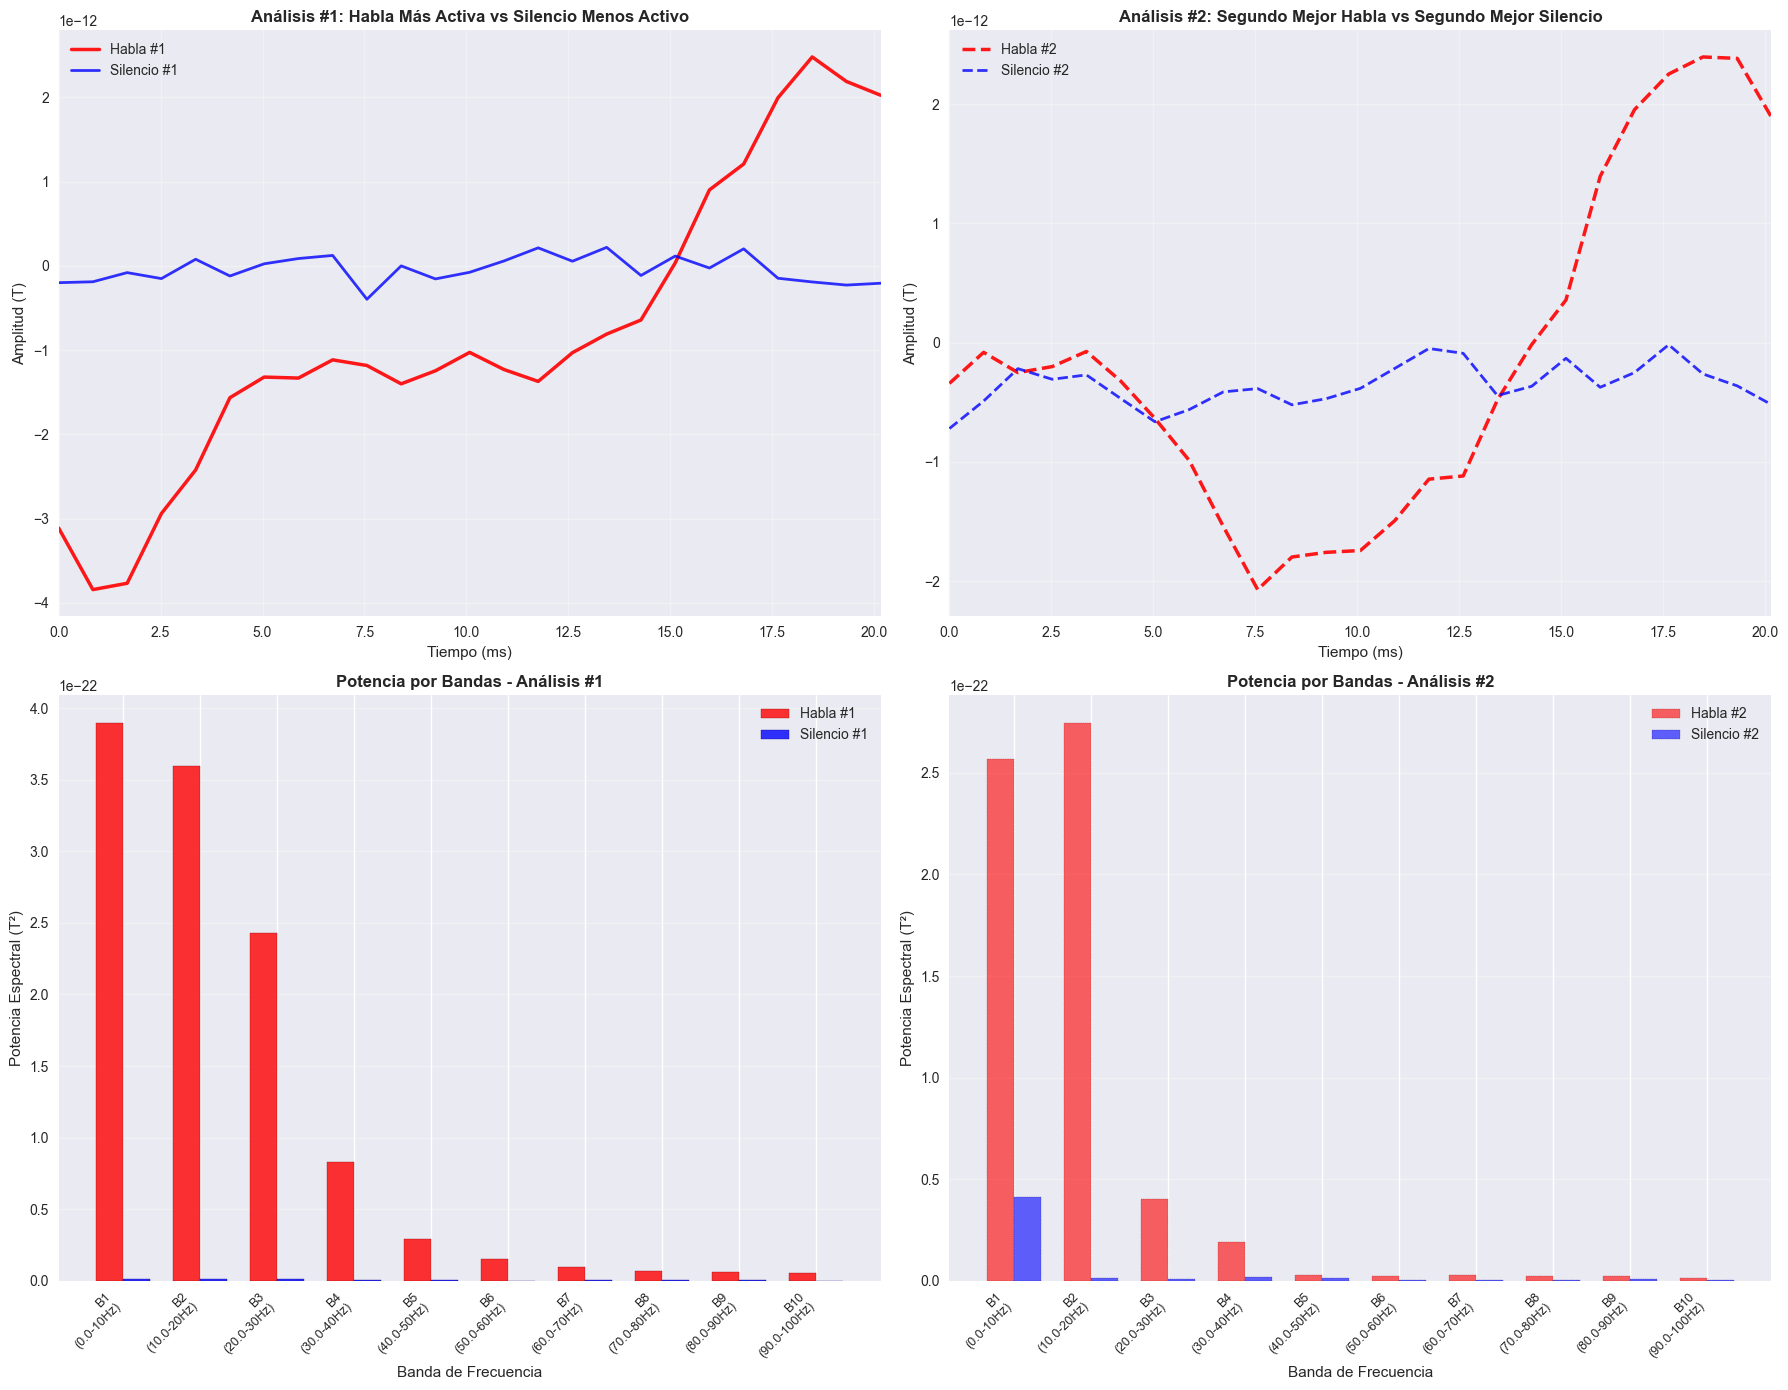

In [65]:
# Tercer análisis ultra-corto y comparación de los 4 segmentos

# Definir zonas de exclusión más amplias para evitar superposición
exclusion_margin_large = int(2.0 * SFREQ)  # 2 segundos de margen

# Zonas de exclusión de los dos análisis anteriores
exclusions = [
    (ultra_speech_start - exclusion_margin_large, ultra_speech_start + ultra_short_samples + exclusion_margin_large),
    (ultra_silence_start - exclusion_margin_large, ultra_silence_start + ultra_short_samples + exclusion_margin_large)
]

# Función para verificar si un segmento está libre de superposiciones
def is_segment_free(start_idx, exclusions):
    segment_end = start_idx + ultra_short_samples
    for exc_start, exc_end in exclusions:
        if not (segment_end < exc_start or start_idx > exc_end):
            return False
    return True

# Buscar el tercer segmento de habla (segundo más activo que no se superponga)
ultra_speech_candidates_3 = []
for i, start_idx in enumerate(ultra_window_starts):
    if is_segment_free(start_idx, exclusions):
        ultra_speech_candidates_3.append((i, start_idx, ultra_activity_per_window[i]))

# Ordenar por actividad descendente y tomar el mejor
ultra_speech_candidates_3.sort(key=lambda x: x[2], reverse=True)
if ultra_speech_candidates_3:
    ultra_speech_idx_3, ultra_speech_start_3, speech_activity_3 = ultra_speech_candidates_3[0]
else:
    ultra_speech_idx_3, ultra_speech_start_3, speech_activity_3 = ultra_speech_idx, ultra_speech_start, ultra_activity_per_window[ultra_speech_idx]

# Agregar la nueva zona de exclusión
exclusions.append((ultra_speech_start_3 - exclusion_margin_large, ultra_speech_start_3 + ultra_short_samples + exclusion_margin_large))

# Buscar el tercer segmento de silencio (segundo menos activo que no se superponga)
ultra_silence_candidates_3 = []
for i, start_idx in enumerate(ultra_window_starts):
    if is_segment_free(start_idx, exclusions):
        ultra_silence_candidates_3.append((i, start_idx, ultra_activity_per_window[i]))

# Ordenar por actividad ascendente y tomar el mejor
ultra_silence_candidates_3.sort(key=lambda x: x[2])
if ultra_silence_candidates_3:
    ultra_silence_idx_3, ultra_silence_start_3, silence_activity_3 = ultra_silence_candidates_3[0]
else:
    ultra_silence_idx_3, ultra_silence_start_3, silence_activity_3 = ultra_silence_idx, ultra_silence_start, ultra_activity_per_window[ultra_silence_idx]

# Extraer los terceros segmentos
ultra_speech_segment_3 = meg_1min[selected_channel, ultra_speech_start_3:ultra_speech_start_3 + ultra_short_samples]
ultra_silence_segment_3 = meg_1min[selected_channel, ultra_silence_start_3:ultra_silence_start_3 + ultra_short_samples]

# ANÁLISIS FFT DE LOS SEGMENTOS ADICIONALES

# FFT para los terceros segmentos
from scipy.fft import fft, fftfreq

fft_speech_3 = np.abs(fft(ultra_speech_segment_3))
fft_silence_3 = np.abs(fft(ultra_silence_segment_3))

# Usar las mismas frecuencias que en análisis anteriores
freq_ultra_3 = fftfreq(len(ultra_speech_segment_3), 1/SFREQ)
positive_freq_mask_3 = freq_ultra_3 >= 0
fft_speech_positive_3 = fft_speech_3[positive_freq_mask_3]
fft_silence_positive_3 = fft_silence_3[positive_freq_mask_3]
freqs_positive_3 = freq_ultra_3[positive_freq_mask_3]

# Calcular potencia en cada banda para los terceros segmentos usando las mismas bandas
band_powers_speech_ultra_3 = []
band_powers_silence_ultra_3 = []

for band_name, (low_freq, high_freq) in bands_ultra.items():
    freq_mask_ultra_3 = (freqs_positive_3 >= low_freq) & (freqs_positive_3 <= high_freq)
    
    if np.any(freq_mask_ultra_3):
        power_speech = np.mean(fft_speech_positive_3[freq_mask_ultra_3]**2)
        power_silence = np.mean(fft_silence_positive_3[freq_mask_ultra_3]**2)
    else:
        power_speech = 0
        power_silence = 0
    
    band_powers_speech_ultra_3.append(power_speech)
    band_powers_silence_ultra_3.append(power_silence)

band_powers_speech_ultra_3 = np.array(band_powers_speech_ultra_3)
band_powers_silence_ultra_3 = np.array(band_powers_silence_ultra_3)

# COMPARACIÓN DE LOS 4 SEGMENTOS

# Crear figura con 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Vector de tiempo común con paso de 0.84 ms
time_step_ms = 0.84
times_ultra_ms_common = np.arange(ultra_short_samples) * time_step_ms

# Plot 1: Primer análisis (habla más activa vs silencio menos activo)
ax1.plot(times_ultra_ms_common, ultra_speech_segment, 'r-', linewidth=2.5, alpha=0.9, label='Habla #1')
ax1.plot(times_ultra_ms_common, ultra_silence_segment, 'b-', linewidth=2, alpha=0.8, label='Silencio #1')
ax1.set_xlabel('Tiempo (ms)', fontsize=11)
ax1.set_ylabel('Amplitud (T)', fontsize=11)
ax1.set_title('Análisis #1: Habla Más Activa vs Silencio Menos Activo', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, times_ultra_ms_common[-1])

# Plot 2: Segundo análisis 
ax2.plot(times_ultra_ms_common, ultra_speech_segment_3, 'r--', linewidth=2.5, alpha=0.9, label='Habla #2')
ax2.plot(times_ultra_ms_common, ultra_silence_segment_3, 'b--', linewidth=2, alpha=0.8, label='Silencio #2')
ax2.set_xlabel('Tiempo (ms)', fontsize=11)
ax2.set_ylabel('Amplitud (T)', fontsize=11)
ax2.set_title('Análisis #2: Segundo Mejor Habla vs Segundo Mejor Silencio', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, times_ultra_ms_common[-1])

# Plot 3: Comparación de potencias por banda - Análisis 1
x_pos_comp = np.arange(len(band_names_ultra))
width_comp = 0.35

bars1_comp = ax3.bar(x_pos_comp - width_comp/2, band_powers_speech_ultra, width_comp, 
                     label='Habla #1', color='red', alpha=0.8, edgecolor='darkred')
bars2_comp = ax3.bar(x_pos_comp + width_comp/2, band_powers_silence_ultra, width_comp, 
                     label='Silencio #1', color='blue', alpha=0.8, edgecolor='darkblue')

ax3.set_xlabel('Banda de Frecuencia', fontsize=11)
ax3.set_ylabel('Potencia Espectral (T²)', fontsize=11)
ax3.set_title('Potencia por Bandas - Análisis #1', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos_comp)
ax3.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Comparación de potencias por banda - Análisis 2
bars3_comp = ax4.bar(x_pos_comp - width_comp/2, band_powers_speech_ultra_3, width_comp, 
                     label='Habla #2', color='red', alpha=0.6, edgecolor='darkred', linestyle='--')
bars4_comp = ax4.bar(x_pos_comp + width_comp/2, band_powers_silence_ultra_3, width_comp, 
                     label='Silencio #2', color='blue', alpha=0.6, edgecolor='darkblue', linestyle='--')

ax4.set_xlabel('Banda de Frecuencia', fontsize=11)
ax4.set_ylabel('Potencia Espectral (T²)', fontsize=11)
ax4.set_title('Potencia por Bandas - Análisis #2', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos_comp)
ax4.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ANÁLISIS ESTADÍSTICO COMPARATIVO

# Estadísticas temporales
activities = [
    ultra_activity_per_window[ultra_speech_idx],
    ultra_activity_per_window[ultra_silence_idx], 
    speech_activity_3,
    silence_activity_3
]

segment_names = ['Habla #1', 'Silencio #1', 'Habla #2', 'Silencio #2']
start_times = [
    ultra_speech_start/SFREQ,
    ultra_silence_start/SFREQ,
    ultra_speech_start_3/SFREQ,
    ultra_silence_start_3/SFREQ
]

# Comparación de ratios
ratio_1 = activities[0] / activities[1] if activities[1] > 0 else float('inf')
ratio_2 = activities[2] / activities[3] if activities[3] > 0 else float('inf')

# Estadísticas de amplitud
segments = [ultra_speech_segment, ultra_silence_segment, ultra_speech_segment_3, ultra_silence_segment_3]
for i, (name, segment) in enumerate(zip(segment_names, segments)):
    mean_amp = np.mean(np.abs(segment))
    std_amp = np.std(segment)
    max_amp = np.max(np.abs(segment))

# Correlación entre segmentos
from scipy.stats import pearsonr
correlations = {}
for i, name1 in enumerate(segment_names):
    for j, name2 in enumerate(segment_names):
        if i < j:
            corr = pearsonr(segments[i], segments[j])[0]
            correlations[f"{name1} vs {name2}"] = corr

# Comparación de potencias espectrales
avg_power_speech_1 = np.mean(band_powers_speech_ultra)
avg_power_silence_1 = np.mean(band_powers_silence_ultra)
avg_power_speech_2 = np.mean(band_powers_speech_ultra_3)
avg_power_silence_2 = np.mean(band_powers_silence_ultra_3)

# Correlación entre análisis
from scipy.stats import pearsonr
corr_speech = pearsonr(band_powers_speech_ultra, band_powers_speech_ultra_3)[0]
corr_silence = pearsonr(band_powers_silence_ultra, band_powers_silence_ultra_3)[0]

# Banda con mayor diferencia
band_ratios_1 = band_powers_speech_ultra / (band_powers_silence_ultra + 1e-10)
band_ratios_2 = band_powers_speech_ultra_3 / (band_powers_silence_ultra_3 + 1e-10)
ratio_difference = np.abs(band_ratios_1 - band_ratios_2)
max_diff_idx = np.argmax(ratio_difference)
max_diff_band = band_names_ultra[max_diff_idx]